## Statistical Methods in Python For Rare Event Searches

*Summer Course at Canfranc Underground Laboratory (LSC) July 2019*

### Lecture V

## Hypothesis test and regression

*Author: Jose A. Hernando*, June 2019

*Instituto Galego de Altas Enerxías. Universidade de Santiago de Compostela, Spain.*

These is a series of lectures on statistical method for rare searches in Particle Physics in Python. Emphasis is put on Hypothesis testing and Confidence Intervals. They are based on the excellent lectures on statistics by Prosper [1], Cowan [2] and Cranmer[3] given at CERN Academic Training.

We will use the Python scientic toolkits, Matplotlib, Numpy, Scipy, that are distributed with Anaconda Python [9]. 

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize

# possible styles: ggplot (simplicity), bmh (scientify data), 
plt.style.context('seaborn-colorblind')

import htcore    as htcore
import htcatalog as htcata
import httoys    as httoys
import htplot    as htplot

# ploting images
from IPython.display import display, Image

In [6]:
import time

print(' Last Execution ', time.asctime())

 Last Execution  Fri Jul  5 11:03:56 2019


----

## Introduction

As we have seen in the previous lecture, there is a relation between hypothesis testing, CI and regression. To obtain a CI using FC ordering we need to estimate the parameter $\mu$.

We are going to revisit here some of **regression** techniques in particular the extended maximum likelihood, EML.



**regression** is the task of estimating the parameters, $\mu$, of a model using data, $x$.
The most common regression methods are the Least Squares (LS) and the Maximum Likelihood (ML).

**goodness of the fit** is the task to quantify the agreement between a dataset and a model or between datasets. 

A typical example is to check if the model obtained by regression is consistent with the original dataset. Another example is to check if two datasets are consistent. 

The most common goodness of the fit used are the $\chi^2$ and the Kolmogorov-Smirnov. The later is only valid in 1D problems. 

Extending goodness of the fit to multivariate datasets is not simple. It is still an open issue

## Extended Maximun Likelihood 

The MLE estimator maximizes:

$$
 \ln \mathcal{L}(\mu) = \sum_{i=1}^n \log g(x_i | \mu).
$$

where $g(x | \mu)$ is the pdf of x, and $\{x\}$ a n-size sample.


**Remember** MLE may not be optimal! and that there is no goodness-of-fit for MLE!

### Extended Maximum Likelihood

The extended maximun likelihood is convenient when we have events of different clases, each one with its one pdf.

Consider the case of $n$-size sample $x$, each $x_i$ distributed with a pdf $g(x | \mu)$, and $n$ is poisson distributed $g(n | \nu)$. The complete likelihood is:

$$
\mathcal{L}(\nu,\mu) = \frac{\nu^n}{n!} e^{-\nu} \Pi_{i=1}^n g(x_i|\mu)
$$

And it is called **Extended Maximum Likelihood function**.

In the cases where $\nu$ depends on $\mu$, we must use EML. If $\nu$ is independent of $\mu$, then $\hat{\nu} = n$, and we recover the ML result.


### Signal and background samples combined

Consider two types of samples, background and signal, each one has a given pdf in one variable $x$:

$$
g_b(x | \mu_b), \; g_s(x | \mu_s)
$$ 

We measure a $n$-size sample of $x$ Each $x_i$ can be from signal or background. And signal and background are poisson distributed with means $\nu_s, \, \nu_b$.

The number of events is poisson distributed:

$$
g_e(n|\nu_s,\nu_b) = \frac{(\nu_s+\nu_b)^n}{n!} e^{-(\nu_s+\nu_b)}
$$

And the $x$ variables is distributed with the weighted pdfs:

$$
g(x|\nu_s,\nu_s, \mu_s, \mu_b) = \frac{\nu_s}{\nu_s+\nu_b} g_s(x | \mu_s) + \frac{\nu_b}{\nu_s+\nu_b} g_b(x | \mu_b)
$$


The complete, extended, pdf is:
$$
g(n, x | \nu_s,\nu_b, \mu_s, \mu_b) = g_e(n|\nu_s,\nu_b) \, g(x|\nu_s,\nu_b, \mu_s, \mu_b)
$$

That is:

$$
 \frac{(\nu_s+\nu_b)^n}{n!} e^{-(\nu_s+\nu_b)} \; \left( \frac{\nu_s}{\nu_s+\nu_b} g_s(x | \mu_s) + \frac{\nu_b}{\nu_s+\nu_b} g_b(x | \mu_b) \right)
$$

where the fraction of signal and background events, $f_s, \, f_b$, are:

$$
f_s = \frac{\nu_s}{\nu_s+\nu_b}, \; f_b = \frac{\nu_b}{\nu_s+\nu_b}
$$

**Exercise:** Consider an dataset with $n$ samples of a measurement $x$. The samples can be either background or signal. For the background $x$ follows and exponential and for the signal a gaussian. Use EML to compute the number of signal and background events in a dataset.

Consider the case of the exponential $\tau = -0.1$, and gaussian with mean $\mu = 2.5$ and sigma $\sigma = 0.1$; $\nu_b = 100$ events for the background and $\nu_s = 20$ for the signal.

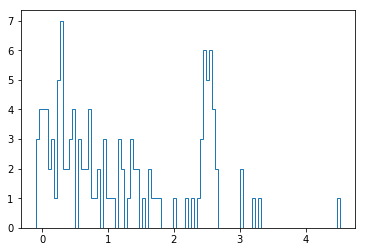

In [101]:
nug, nub, tau, gmu, gsig, size = 20., 100., -0.1, 2.5, 0.1, 1
par = [nug, nub, tau, gmu, gsig]
rv  = htcata.extended_norm_expon
xs = rv.rvs(*par, size = size)
xs = np.concatenate(xs); x0 = xs.flatten() # add several datasets
plt.hist(xs, 100, histtype = 'step');

In [102]:
mask, masknu = (True, True, False, False, False), (False, True, False, False, False)
ht = htcore.htcomposite(rv, par, mask = mask, masknu = masknu)
parbest = ht.parbest(x0)
print('parbest ', parbest)

parbest  [25.39506292 93.60492481 -0.1         2.5         0.1       ]


**Exercise**: Check is the case fulfills the Wilk's condition.

chi2  1.0728216837730762
p-value mean : 0.5175868714039004 ; std * sqrt(12.) : 0.9952688722019466


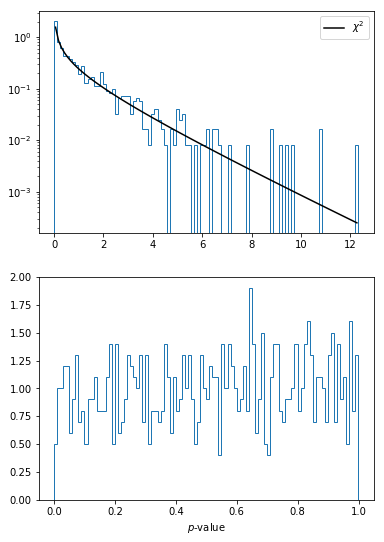

In [89]:
tmus = ht.tmu_rvs(size = 1000);
htplot.chi2_test(tmus);

**Exercise**: Compute the CI at 68 % CL using $t_\mu(x)$ and the p0-value for the case $\nu_g = 0$.

In [91]:
beta = 0.90
ci = ht.tmu_cint(x0, parbest = parbest, beta = beta)
#ul = ht.qmu_ulim(x0, parbest = parbest, beta = beta)
q0 = ht.q0(x0, 0., parbest = parbest)
p0 = htcore.q0_pvalue(q0)
htplot.prt_wilks_pvalues(beta, ci_central = ci, p0 = p0)

central CI  : [10.30176774 25.32851881] at  90 % CL
p0 value    : 2.102124030400887e-10


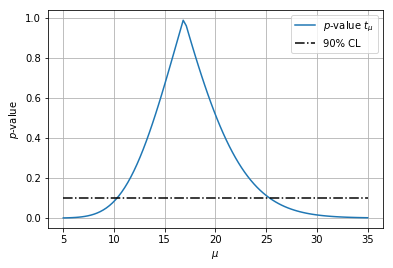

In [94]:
mus   = np.linspace(max(0., nug - 15), nug + 15, 100)
tmus  = [ht.tmu(x0, mui, parbest = parbest) for mui  in mus]
ptmus = [htcore.tmu_pvalue(tmui)            for tmui in tmus]
htplot.plt_wilks_pvalues(beta, mus, ptmus);

**Exercise**: Consider now a uniform backgrund $1.3 \times 10^{-4}$ c/(kg y keV) and and two gaussian peaks with sigma 1%, one signal peak, $^{136}$Xe at 4458 keV with unknown number of events and other background peak ($^{214}$Bi) at 4447 keV with 0.06 c/(keV y). Consider the range 2400-2500 keV. 

Compute the upper limit in number of signal events at 90% CL vs exposure in the case there is no signal. 

Compute the observation potential in the case the number of signal is 0.12 c/(keV y).